In [1]:
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from main import prognose
from scipy import stats
import seaborn as sns
print(" Danke für die Spielwiese :) ")

 Danke für die Spielwiese :) 


C:\Users\mirko\anaconda3\envs\sixSigma\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
df = pandas.read_csv('gesamtdaten_energien.csv', index_col=0)
df_copy = df.copy()

AxesSubplot(0.125,0.657941;0.775x0.222059)
(18231,)
Prognosewert: x <=	 0.0004 W
AxesSubplot(0.125,0.391471;0.775x0.222059)
(18210,)
Prognosewert: x <=	 0.0001 W
AxesSubplot(0.125,0.125;0.775x0.222059)
(16892,)
Prognosewert: x <=	 0.0001 W


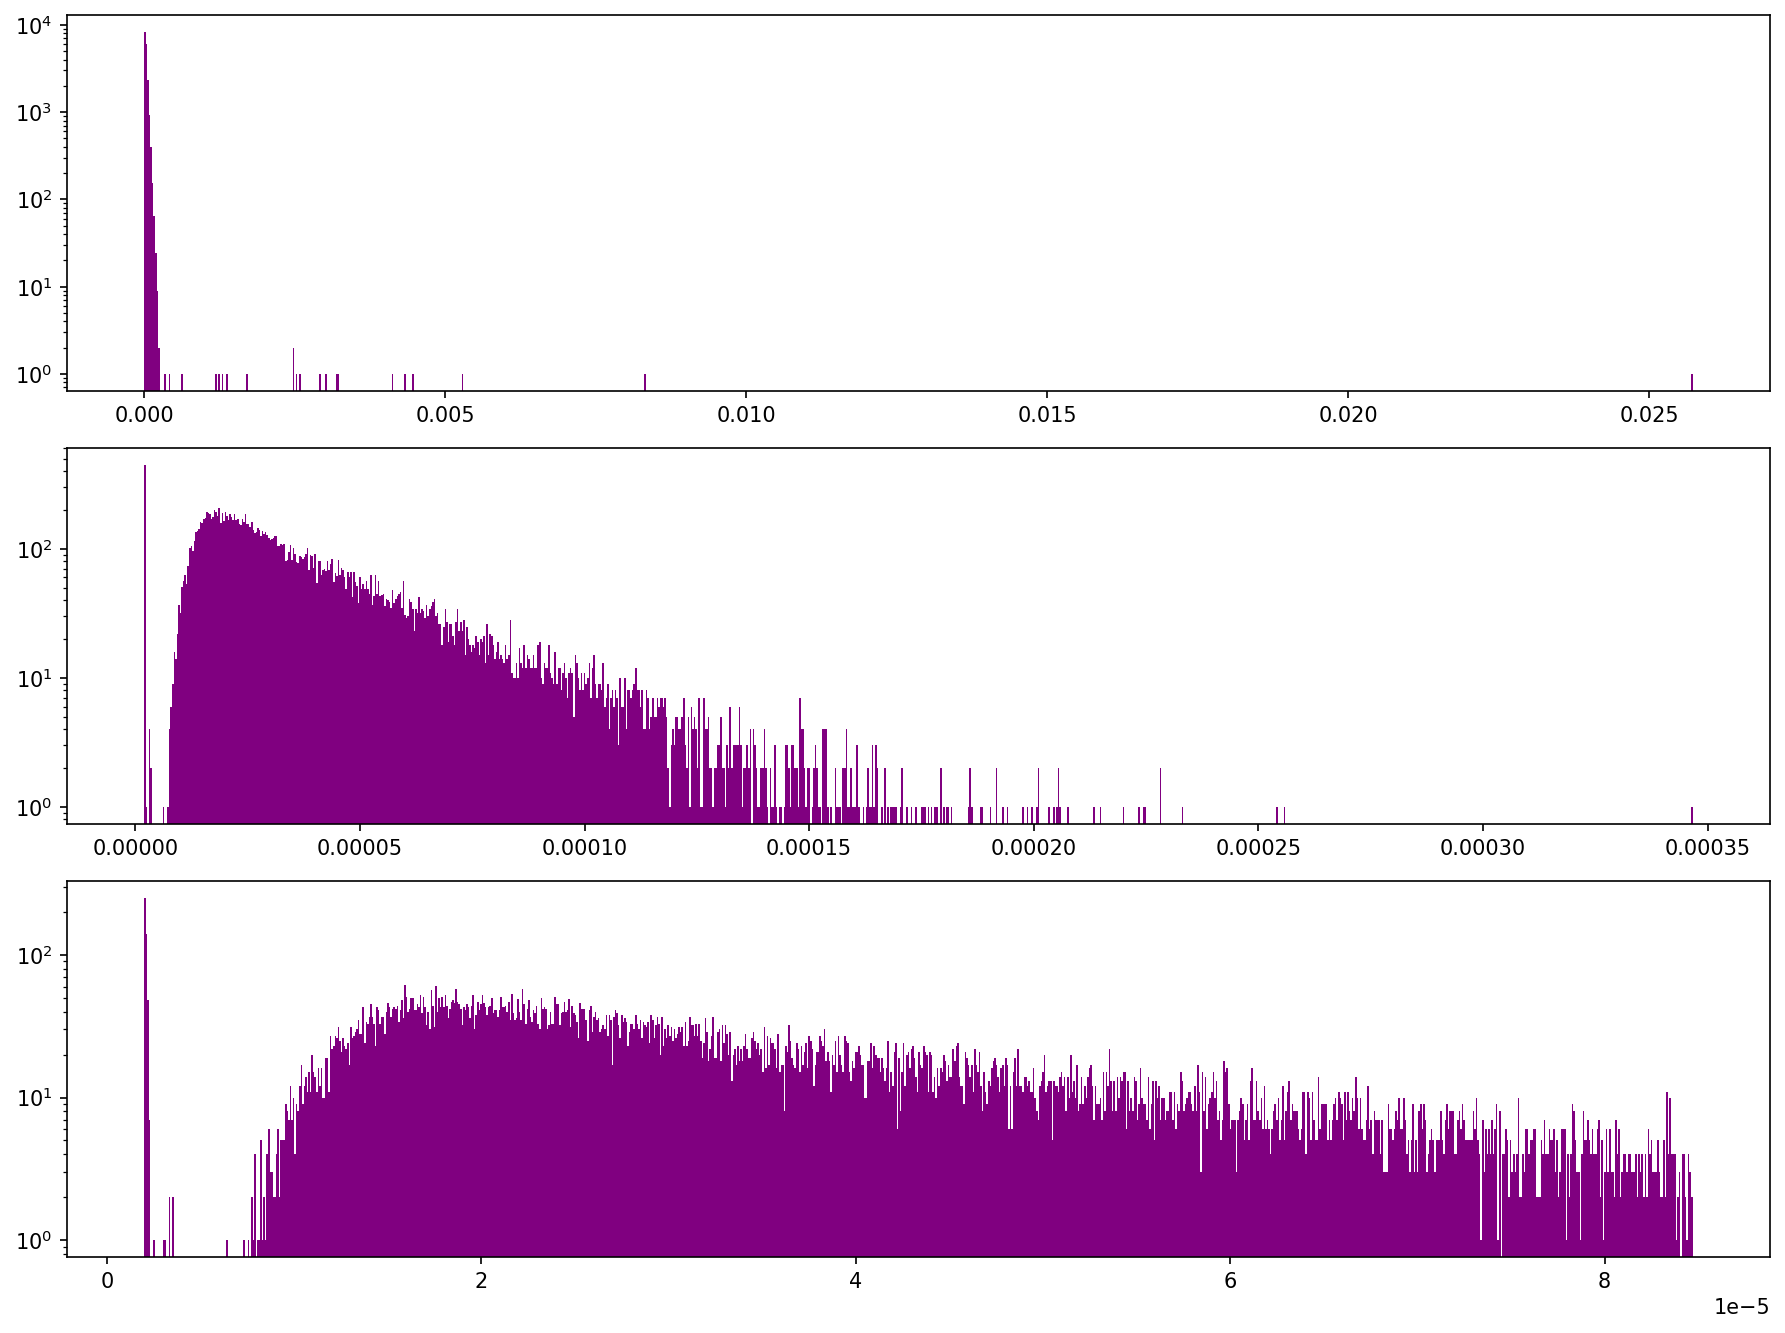

In [3]:
plt.rcParams['figure.dpi'] = 150
# plt.rcParams['interactive'] = True
plt.rcParams['figure.figsize'] = (12, 9)
sieb_energien = pandas.read_csv('gesamtdaten_energien.csv', index_col=0)
fig, ax = plt.subplots(3,1)#, sharey='all')
pwr = sieb_energien['GesamtEnergie'].copy()/2**15

for i in ax:
    print(i)
    print(pwr.shape)
    pwr[:].hist(bins=1000, grid=True, color='purple',log=True,ax=i)
    progmax = prognose(pwr.to_numpy(), gamma=0.95)
    print
    # siebe nun anhand der prognostizierten Schwellenwerte.
    for x in pwr.index:
        if pwr.loc[x] > progmax:
            pwr = pwr.drop(x).copy()
    i.grid()

fig.tight_layout()
plt.show()

#sieb_energien.plot.hist()

In [28]:
#fig, ax = plt.subplots(3,1)#, sharey='all')
pwr = sieb_energien['GesamtEnergie'].copy()/2**15

fitted_data, fitted_lambda = stats.boxcox(pwr)


fitted_data = pandas.Series(fitted_data, index= pwr.index)
# plotting the original data(non-normal) and
# fitted data (normal)


#sns.distplot(pwr, hist = False, kde = True,
#            kde_kws = {'shade': True, 'linewidth': 2},
#            label = "Non-Normal", color ="green", ax = ax[0])
#
#sns.distplot(fitted_data, hist = False, kde = True,
#            kde_kws = {'shade': True, 'linewidth': 2},
#            label = "Normal", color ="green", ax = ax[1])


#prob = stats.probplot(pwr, dist=stats.norm, plot=ax[0])
#prob = stats.probplot(fitted_data, dist=stats.norm, plot=ax[1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


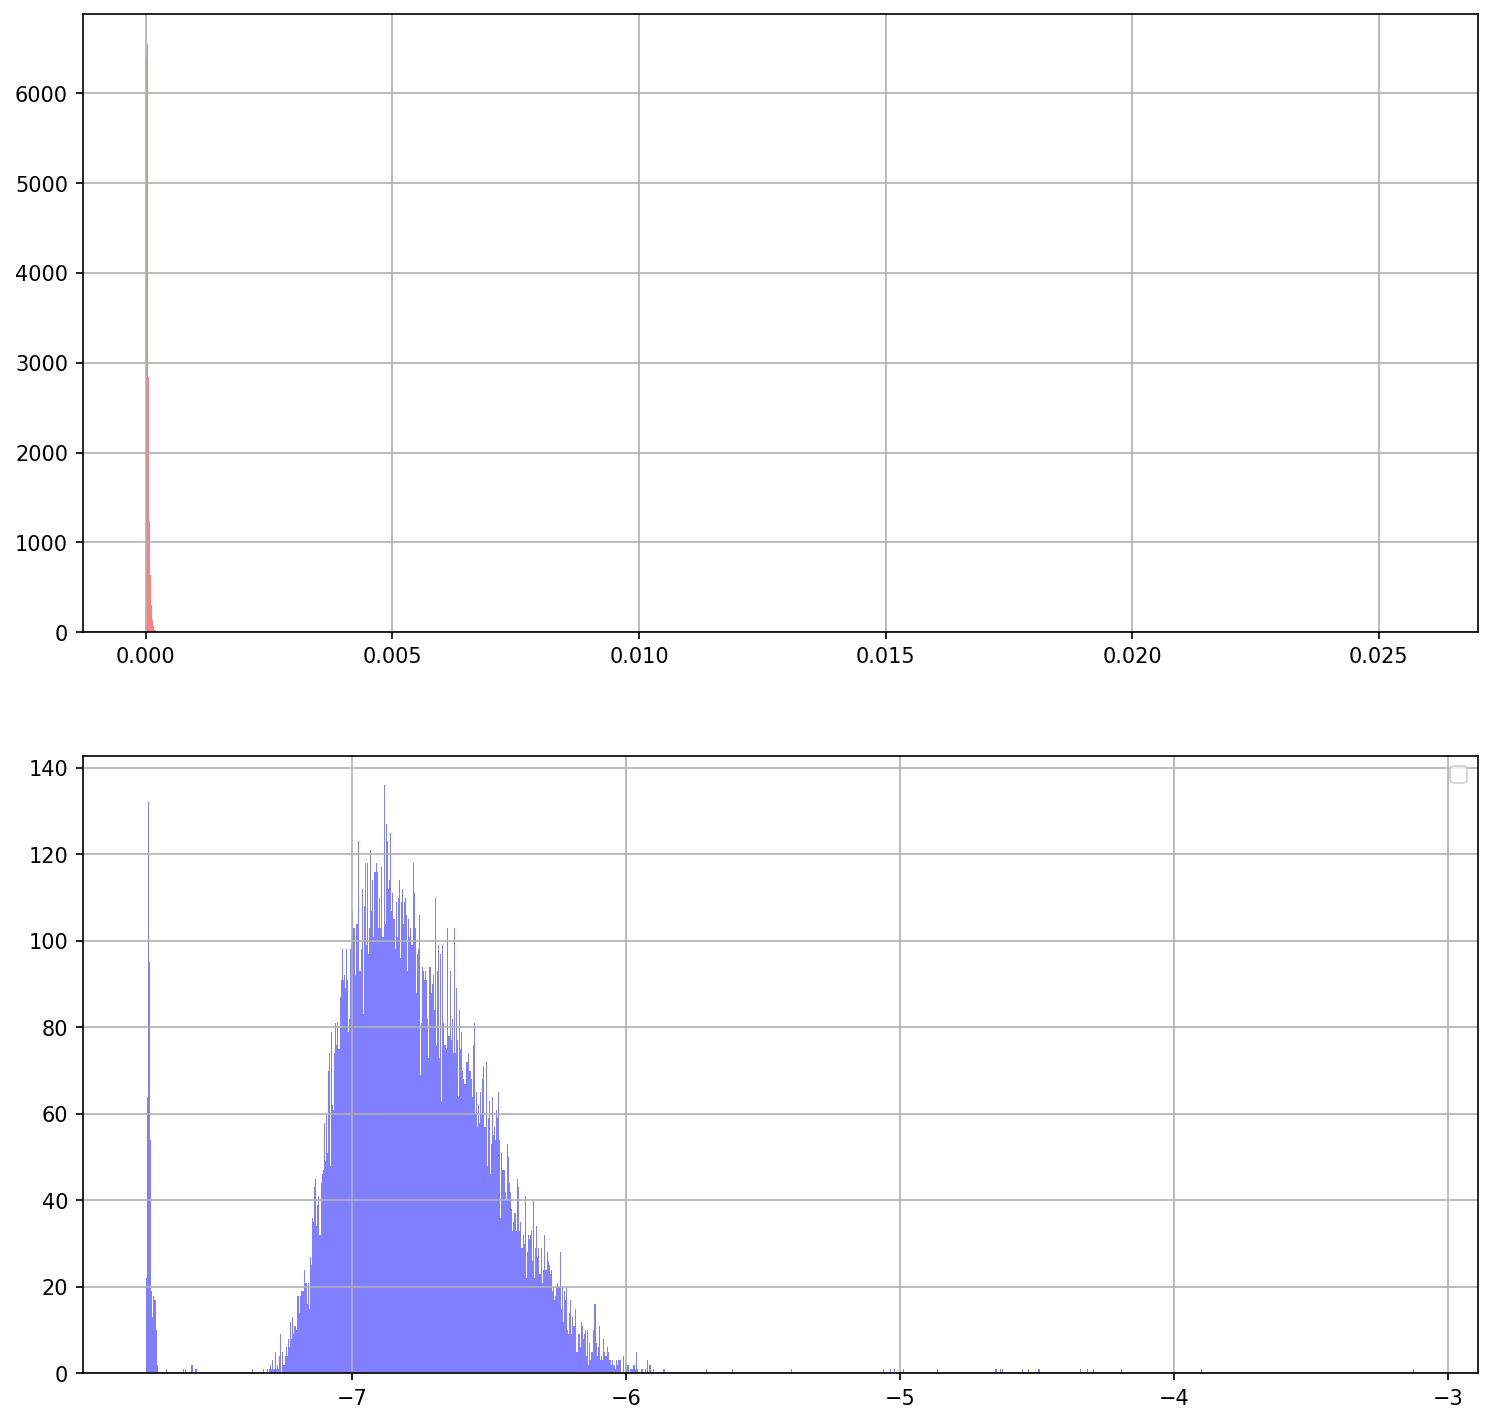

Lambda value used for Transformation: 0.08880461775870223


In [49]:
fig, ax = plt.subplots(2,1, figsize=(12, 12))# sharex='col', sharey='row')
n = 2
n_bins = 1200
bins = np.linspace(pwr.min(), pwr.max(), n_bins) #Create bins of equal size between min_value and max_value

pwr.hist(bins=bins, ax=ax[0], alpha=0.5, color='red')

bins = np.linspace(fitted_data.min(), fitted_data.max(), n_bins) #Create bins of equal size between min_value and max_value

fitted_data.hist(bins=bins, ax=ax[1], alpha=0.5, color='blue')
#ax[i].set_title(df.columns[i][2:])
plt.legend(loc = "upper right")
plt.show()
print(f"Lambda value used for Transformation: {fitted_lambda}")

In [8]:
print(pwr)
print(fitted_data)

 20220509_16_09_32.wav    0.000008
 20220509_16_09_35.wav    0.003215
 20220509_16_09_38.wav    0.001378
 20220509_16_09_41.wav    0.000421
 20220509_16_09_44.wav    0.001206
                            ...   
 20220510_09_28_13.wav    0.000021
 20220510_09_28_16.wav    0.000041
 20220510_09_28_19.wav    0.000014
 20220510_09_28_22.wav    0.000017
 20220510_09_28_25.wav    0.000020
Name: GesamtEnergie, Length: 18231, dtype: float64
[-7.29355191 -4.49692456 -4.98693355 ... -7.08754447 -7.00784193
 -6.95806369]
